In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv("water_quality_500rowsV2.csv")
df = df.drop(columns=["Index"], errors="ignore")

# Fitur training
features_train = [
    "pH",
    "Color",
    "Turbidity",
    "Odor",
    "Source",
    "Total Dissolved Solids",
    "Manganese",
    "Iron"
]

target = "Target"

df_model = df[features_train + [target]].copy()

Memisahkan fitur yg numerik dan kategorikal

In [ ]:

numeric_features = [
    "pH",
    "Turbidity",
    "Odor",
    "Total Dissolved Solids",
    "Manganese",
    "Iron"
]

categorical_features = [
    "Color",
    "Source"
]

Preprocessing

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Build Model Random Forest

In [ ]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

In [ ]:

# Train-test split
X = df_model[features_train]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pH', 'Turbidity', 'Odor',
                                                   'Total Dissolved Solids',
                                                   'Manganese', 'Iron']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Color', 'Source'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

Evaluation

In [ ]:
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        46
           1       0.82      0.85      0.84        54

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



buat save model

In [ ]:
with open("water_quality_rf_modelV3.pkl", "wb") as f:
    pickle.dump(model, f)

print("\nModel saved as water_quality_rf_model.pkl")


Model saved as water_quality_rf_model.pkl


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# === Tambahan Evaluasi Regressor-like (MSE, RMSE, R2) ===
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nMSE      :", mse)
print("RMSE     :", rmse)
print("R² Score :", r2)



MSE      : 0.14
RMSE     : 0.37416573867739417
R² Score : 0.43999999999999995


CONFUSION MATRIX

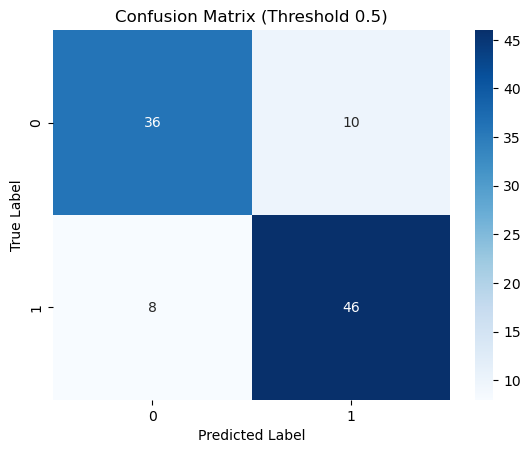

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Threshold 0.5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

FEATURE IMPORTANCE

C:\Users\xxonyx\AppData\Local\Temp\ipykernel_25032\3605771417.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")


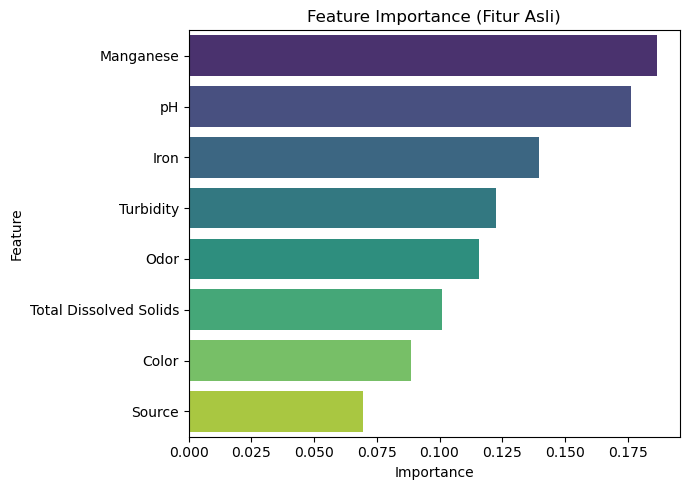

,Feature,Importance
4,Manganese,0.186523
0,pH,0.176253
5,Iron,0.139828
1,Turbidity,0.122633
2,Odor,0.115775
3,Total Dissolved Solids,0.100949
6,Color,0.088682
7,Source,0.069356


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pre = model.named_steps["preprocessor"]
rf = model.named_steps["clf"]

num_feats = numeric_features.copy()

cat_encoder = pre.named_transformers_["cat"].named_steps["encoder"]
cat_ohe_feats = list(cat_encoder.get_feature_names_out(categorical_features))

# menggabungkan seluruh nama fitur transformasi
all_transformed_features = num_feats + cat_ohe_feats

# ngambil importance
importances = rf.feature_importances_

# importance untuk fitur kategorikal
feature_importance_final = {}

# Numerik -> langsung ambil importance
for f in numeric_features:
    idx = all_transformed_features.index(f)
    feature_importance_final[f] = importances[idx]

# Kategorikal -> jumlahkan semua variabel
for cat_feat in categorical_features:
    related_cols = [col for col in cat_ohe_feats if col.startswith(cat_feat)]
    total_imp = sum(importances[all_transformed_features.index(col)] for col in related_cols)
    feature_importance_final[cat_feat] = total_imp

# Konversi ke DataFrame
feat_imp_df = pd.DataFrame({
    "Feature": list(feature_importance_final.keys()),
    "Importance": list(feature_importance_final.values())
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance (Fitur Asli)")
plt.tight_layout()
plt.show()

feat_imp_df
